 Data loaded successfully!
Raw data: 100 records
Incremental data: 10 records

=== TRANSFORMATION 1: REMOVE DUPLICATES ===
Before: 100 records
After: 99 records
Removed 1 duplicate(s)

=== TRANSFORMATION 2: HANDLE MISSING VALUES ===

Missing values BEFORE cleaning:


order_id          0
customer_name     1
product           0
quantity         26
unit_price       35
order_date        1
region           25
dtype: int64


Missing values AFTER cleaning:


order_id         0
customer_name    0
product          0
quantity         0
unit_price       0
order_date       0
region           0
dtype: int64


=== TRANSFORMATION 3: ADD CALCULATED COLUMNS ===
Added 'total_price' column:


,quantity,unit_price,total_price
0,1,500.0,500.0
1,1,250.0,250.0
2,2,250.0,500.0
3,2,750.0,1500.0
4,3,500.0,1500.0



=== TRANSFORMATION 4: CREATE ORDER SIZE CATEGORIES ===
Order size distribution:


order_size
Large     46
Medium    32
Small     21
Name: count, dtype: int64


=== TRANSFORMATION 5: CONVERT DATA TYPES ===
Before conversion:


order_id            int64
customer_name      object
product            object
quantity            int32
unit_price        float64
order_date         object
region             object
total_price       float64
order_size       category
dtype: object


After conversion:


order_id                 object
customer_name            object
product                  object
quantity                  int32
unit_price              float64
order_date       datetime64[ns]
region                   object
total_price             float64
order_size             category
dtype: object

 Transformed data saved to:
- transformed/transformed_full.csv
- transformed/transformed_incremental.csv

=== TRANSFORMATION SUMMARY ===
Performed 5 key transformations:
1. Removed duplicate records
2. Handled all missing values
3. Added calculated total_price column
4. Created order_size categories
5. Converted data types

Sample of transformed data:


,order_id,customer_name,product,quantity,unit_price,order_date,region,total_price,order_size
0,1,Diana,Tablet,1,500.0,2024-01-20,South,500.0,Medium
1,2,Eve,Laptop,1,250.0,2024-04-29,North,250.0,Small
2,3,Charlie,Laptop,2,250.0,2024-01-08,Unknown,500.0,Medium


C:\Users\Admin\AppData\Local\Temp\ipykernel_17692\1396013789.py:169: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


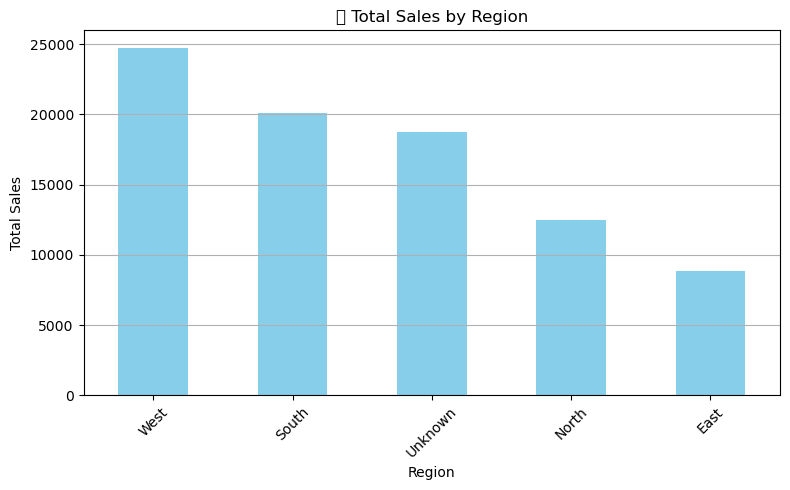

<Figure size 640x480 with 0 Axes>

In [6]:
# %% [markdown]
# # ETL Pipeline - Transform Phase
# **Kevin (ID: 656)**  
# DSA 2040 A US 2025 Mid Semester Exam

# %% [markdown]
# ## 1. Import Libraries and Load Data

# %%
import pandas as pd
import numpy as np
from IPython.display import display

# Load the extracted data
raw_df = pd.read_csv('data/raw_data.csv')
inc_df = pd.read_csv('data/incremental_data.csv')

print(" Data loaded successfully!")
print(f"Raw data: {raw_df.shape[0]} records")
print(f"Incremental data: {inc_df.shape[0]} records")

# %% [markdown]
# ## 2. Data Cleaning Transformations

# %%
# Transformation 1: Remove duplicates
print("\n=== TRANSFORMATION 1: REMOVE DUPLICATES ===")
print(f"Before: {raw_df.shape[0]} records")

raw_df = raw_df.drop_duplicates(subset=['order_id'], keep='first')

print(f"After: {raw_df.shape[0]} records")
print(f"Removed {100 - raw_df.shape[0]} duplicate(s)")

# %%
# Transformation 2: Handle missing values
print("\n=== TRANSFORMATION 2: HANDLE MISSING VALUES ===")

def clean_missing(df):
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Fill missing customer names
    df['customer_name'] = df['customer_name'].fillna('Unknown')
    
    # Fill missing quantities (minimum 1)
    df['quantity'] = df['quantity'].fillna(1).astype(int)
    
    # Fill unit prices with product median
    product_medians = df.groupby('product')['unit_price'].median()
    df['unit_price'] = df.apply(
        lambda row: product_medians[row['product']] if pd.isna(row['unit_price']) else row['unit_price'],
        axis=1
    )
    
    # Fill missing regions
    df['region'] = df['region'].fillna('Unknown')
    
    # Fill missing dates with mode (most common date)
    mode_date = df['order_date'].mode()[0]
    df['order_date'] = df['order_date'].fillna(mode_date)
    
    return df

print("\nMissing values BEFORE cleaning:")
display(raw_df.isnull().sum())

raw_df = clean_missing(raw_df)
inc_df = clean_missing(inc_df)

print("\nMissing values AFTER cleaning:")
display(raw_df.isnull().sum())

# %% [markdown]
# ## 3. Data Enrichment Transformations

# %%
# Transformation 3: Add calculated columns
print("\n=== TRANSFORMATION 3: ADD CALCULATED COLUMNS ===")

raw_df['total_price'] = raw_df['quantity'] * raw_df['unit_price']
inc_df['total_price'] = inc_df['quantity'] * inc_df['unit_price']

print("Added 'total_price' column:")
display(raw_df[['quantity', 'unit_price', 'total_price']].head())

# %%
# Transformation 4: Create order size categories
print("\n=== TRANSFORMATION 4: CREATE ORDER SIZE CATEGORIES ===")

bins = [0, 300, 700, float('inf')]
labels = ['Small', 'Medium', 'Large']

raw_df['order_size'] = pd.cut(raw_df['total_price'], bins=bins, labels=labels)
inc_df['order_size'] = pd.cut(inc_df['total_price'], bins=bins, labels=labels)

print("Order size distribution:")
display(raw_df['order_size'].value_counts())

# %% [markdown]
# ## 4. Data Structure Transformations

# %%
# Transformation 5: Convert data types
print("\n=== TRANSFORMATION 5: CONVERT DATA TYPES ===")

print("Before conversion:")
display(raw_df.dtypes)

# Convert order_date to datetime
raw_df['order_date'] = pd.to_datetime(raw_df['order_date'])
inc_df['order_date'] = pd.to_datetime(inc_df['order_date'])

# Convert order_id to string
raw_df['order_id'] = raw_df['order_id'].astype(str)
inc_df['order_id'] = inc_df['order_id'].astype(str)

print("\nAfter conversion:")
display(raw_df.dtypes)

# %% [markdown]
# ## 5. Save Transformed Data

# %%
# Save to transformed folder
raw_df.to_csv('transformed/transformed_full.csv', index=False)
inc_df.to_csv('transformed/transformed_incremental.csv', index=False)

print(" Transformed data saved to:")
print("- transformed/transformed_full.csv")
print("- transformed/transformed_incremental.csv")

# %% [markdown]
# ## 6. Transformation Summary

# %%
print("\n=== TRANSFORMATION SUMMARY ===")
print("Performed 5 key transformations:")
print("1. Removed duplicate records")
print("2. Handled all missing values")
print("3. Added calculated total_price column")
print("4. Created order_size categories")
print("5. Converted data types")

print("\nSample of transformed data:")
display(raw_df.head(3))


## 📈 Bonus Visualization: Total Sales by Region
import pandas as pd
import matplotlib.pyplot as plt

# Load your transformed full dataset
df = pd.read_csv("transformed/transformed_full.csv")

# Create a new column if not already added
df['total_price'] = df['quantity'] * df['unit_price']

# Group by region and sum total_price
sales_by_region = df.groupby('region')['total_price'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(8, 5))
sales_by_region.plot(kind='bar', color='skyblue')
plt.title("💰 Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()
plt.savefig("bonus_sales_chart.png")

